# Unbiased estimation of the standard deviation

In this post ....

See: Dr. Dave Giles post [Unbiased Estimation of a Standard Deviation](https://davegiles.blogspot.com/2013/12/unbiased-estimation-of-standard.html) for additional context and inspiration. Section 2 draws heavily on: Note that this section draws heavily on Giles (2021): [Unbiased Estimation of the Standard Deviation for Non-Normal Populations](http://web.uvic.ca/~dgiles/downloads/working_papers/std_dev.pdf).

Motivaiton: estimating the standard deviation (rather than just the variance) can be important for distributions, especially the normal distribution or any of its related distributions (e.g. the truncated normal, folded normal, etc). 

This post was generated from an original notebook that can be found HERE. For readability, various code blocks have been supressed and the text has been tidied up.

Key summary:

1. Review of why the the sample SD is biased with a demonstrative simulation
2. Parametric adjustments w/ python code
3. Non-parametric adjustments w/ python code
4. Applied example for a regression model calculated SD of the MAE/MSE

<br>



## (1) Background

It is well understood that the [sample variance](https://en.wikipedia.org/wiki/Variance#Unbiased_sample_variance), $S^2$ is an unbiased estimate of the variance for any well-behaved continuous distribution.

<br>

$$
\begin{align*}
X &\sim F \hspace{2mm} \text{where $F$ is some continuous dist} \\
\text{Var}(X) &= E([X - E(X)]^2) \\
S^2 &= (n-1)^{-1} \sum_{i=1}^n (X_i - \bar{X})^2 \\ 
\bar{X} &= n^{-1} \sum_{i=1}^n X_i \\
(n-1) E[S^2] &= \sum_{i=1}^n E[(X_i - \mu)^2] - nE[(\bar{X} - \mu)^2] \\
&= \sum_{i=1}^n \sigma^2 - n \text{Var}(\bar{X}) \\
&= n\sigma^2 - n \frac{\sigma^2}{n} \\
&= (n-1) \sigma^2 \hspace{2mm} \longleftrightarrow \\
E[S^2] &= \sigma^2
\end{align*}
$$

This fact is pretty remarkable. For any finite sample, using [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction) provides an unbiased estimate of the second moment of any distribution. Of course, the variance of the sample variance estimator $S^2$ will increase the smaller the sample size, but the magnitude of the variation can be estimated using standard non-parametric approaches. While $S^2$ is an unbiased estimate of the population variance, will $S$ be an unbiased estimate of the population standard deviation?

The short answer is no: an unbiased estimator is generally not invariant under parameter transformations. Why is this the case? It's because of [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality#Probabilistic_form): the function of an expectation of a random variable, will not (in general) be equal to the expectation of a function of a random variable. 

$$
\begin{align*}
\text{SD}(X) &= \sqrt{\text{Var}(X)} \\
&= \sqrt{E([X - E(X)]^2)} = \sqrt{\sigma^2} = \sigma \\
E[S^2] &=  (n-1)^{-1} \sum_{i=1}^n E(X_i - \bar{X})^2 = \sigma^2 \\
E[S] &= E\Bigg\{ \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2 \Bigg\}^{0.5} \\
&\neq \sigma \hspace{2mm} \text{ by Jensen's inequality}
\end{align*}
$$

In this instance, $S^2$ is the random variable, and the function is a square root transformation. In fact, Jensen's inequality tells us that:

$$
\begin{align*}
E[f(S^2)] &\leq f(E[S^2]) \\
E[S] &\leq \sigma
\end{align*}
$$

When $f(\cdot)$ is a [concave function](https://en.wikipedia.org/wiki/Concave_function), with the square-root transformation is. In other words, taking the square root of the sample variance (i.e. the sample standard deviation) will lead to an under-estimate of the true population standard deviation. We can see this is a simple simulation exerise below.

### Simulation showing bias

Consider a simple single-parameter [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), $X \sim \text{Exp}(\lambda)$ where $\lambda$ is the rate parameter. The moments of the exponential distribution are well defined: $E[X]=\lambda^{-1}$, $E[(X-\lambda^{-1})^2]=\lambda^{-2}$, and so on. The simulation below will consider three different values of $\lambda = \{1/2, 1, 2\}$, and 7 different finite sample sizes: $n=\{2^1, 2^2, \dots, 2^7\}$, and compare the oracle variance and standard deviation to their empirical counterparts.

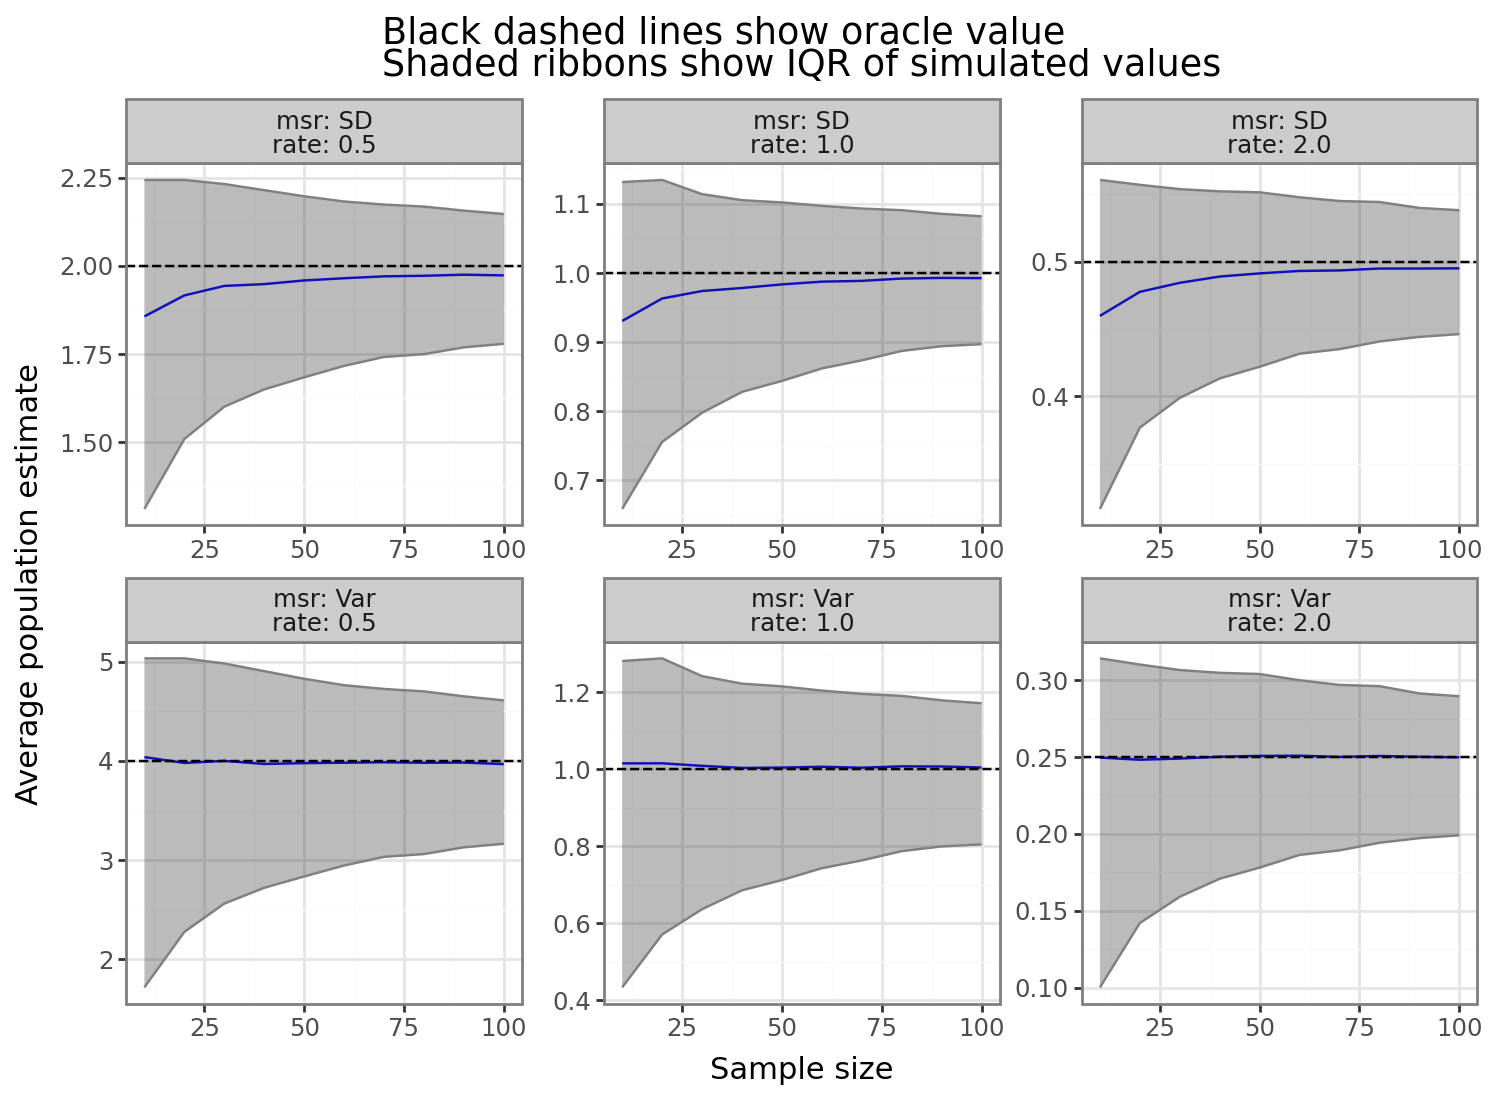

In [30]:
# Import modules to be used throughout post
import numpy as np
import pandas as pd
import plotnine as pn
from scipy.stats import norm, expon
from utils import calculate_summary_stats

nsim = 2500  # Number of simluations
sample_sizes = np.arange(10, 100+1, 10).astype(int)
n_sample_sizes = len(sample_sizes)
rates = np.array([1/2, 1, 2])
n_rates = len(rates)
dist_expon = expon(scale = 1 / rates)
oracle_variance = dist_expon.var()
oracle_sd = np.sqrt(oracle_variance)
# Calculate the oracle quantities
dat_oracle_expon = pd.concat(objs = [pd.DataFrame({'msr':'Var', 'rate':rates, 'oracle':oracle_variance}),
                                     pd.DataFrame({'msr':'SD', 'rate':rates, 'oracle':oracle_sd})])
# Run the simulation
holder_var = np.zeros((nsim, n_sample_sizes, n_rates))
for i in range(nsim):
    sim_var_i = np.vstack([dist_expon.rvs(size=(n, n_rates), random_state=i+1).var(ddof=1, axis=0) for n in sample_sizes])
    holder_var[i] = sim_var_i
# Calculate average results with some variation
res_var = calculate_summary_stats(holder_var, colnames=rates, idxnames=sample_sizes, var_name='rate', value_name='n')
res_sd = calculate_summary_stats(np.sqrt(holder_var), colnames=rates, idxnames=sample_sizes, var_name='rate', value_name='n')
res_expon = pd.concat(objs = [res_var.assign(msr='Var'), res_sd.assign(msr='SD')])

pn.options.figure_size = (7.5, 5.5)
gg_expon = (pn.ggplot(res_expon, pn.aes(x='n', y='mu')) + 
            pn.theme_bw() + pn.geom_line(color='blue') + 
            pn.geom_ribbon(pn.aes(ymin='lb', ymax='ub'),color='grey', alpha=1/3) + 
            pn.facet_wrap('~msr+rate', scales='free', labeller=pn.label_both, nrow=2, ncol=3) + 
            pn.geom_hline(pn.aes(yintercept='oracle'), data=dat_oracle_expon,linetype='--') + 
            pn.labs(y='Average population estimate', x='Sample size') + 
            pn.ggtitle('Black dashed lines show oracle value\nShaded ribbons show IQR of simulated values'))
gg_expon

As the figure above shows, the sample variance is unbiased around the true oracle value for this exponential distribution, whereas the sample standard deviation has a negative bias, as expected, and asymptotes towards the population value. This begs the obvious question: is there anything we can do to address this bias? The rest of this post will provide strategies for doing so.

## (2) Adjustments when the distribution is known

First, consider re-writing $S$ as a function of $\sigma$ (you'll notice the RHS reduces to $S$):

$$
S = \sigma [1 + (S^2 - \sigma^2)/\sigma^2]^{1/2}
$$

Next, consider the [binomial series expansion](https://en.wikipedia.org/wiki/Binomial_series):

$$
(1 + x)^{0.5} = 1 + \frac{x}{2} - \frac{x^2}{8} + \frac{x^3}{16} - \dots
$$

Re-writing $x = (S^2 - \sigma^2)/\sigma^2$ we see that:

$$
S = \sigma \Bigg[1 + \frac{1}{2\sigma^2}(S^2 - \sigma^2) - \frac{1}{8\sigma^4}([S^2 - \sigma^2]^2) + \frac{1}{16\sigma^6}([S^2 - \sigma^2]^3) - \dots \Bigg]
$$

Now we've re-written the sampling SD in terms of an infinite series and removed the square-root, we need to understand how fast the high-order terms tend towards zero as $n$ increases. Remember, $S^2$ is an unbiased estimator of $\sigma^2$ so $S^2-\sigma^2$ always averages to zero, and what we're interested in understanding is how fast the variance decreases. For example, when $X$ comes from a normal distribution, then:

$$
\begin{align*}
S^2 - \sigma^2 &= \sigma^2 \Bigg( \frac{\chi^2_{n-1}}{n-1} -1 \Bigg) \\
&\approx \sigma^2 \cdot N\Bigg(0, \frac{2}{n-1} \Bigg) \\
&\sim N\Bigg(0, \frac{2\sigma^4}{n-1} \Bigg),
\end{align*}
$$

Using the [well-known fact](https://en.wikipedia.org/wiki/Chi-squared_distribution#Related_distributions) that $\chi^2_k \overset{d}{\to} N(k, 2k)$. What's nice is that the sampling distribution actually follows a chi-square distribution [asymptotically](https://stats.stackexchange.com/questions/105337/asymptotic-distribution-of-sample-variance-of-non-normal-sample) for any continuous RV, so we can use the above results for the sampling variance more generally:

$$
\begin{align*}
\frac{S^2 - \sigma^2}{\sigma^2} &\approx \sqrt{\frac{2}{n-1}} Z, \hspace{2mm} Z \sim N(0,1) \\
O\Bigg( \sqrt{\frac{2}{n-1}} Z \Bigg) &= O\Bigg( \frac{1}{\sqrt{n}} \Bigg)  \\
O\Bigg( \frac{S^2 - \sigma^2}{\sigma^2}\Bigg) &= O(n^{-1/2}) \\
O\Bigg( \Bigg[ \frac{S^2 - \sigma^2}{\sigma^2} \Bigg]^k \Bigg) &= O(n^{-k/2})
\end{align*}
$$

We can see that the random variable $(S^2 - \sigma^2)/\sigma^2$ has a sampling error that is root-n consistent. And each time this term is raised to the power of $k$, the sampling error decreases by a rate of $k/2$. When $n$ is large, then $O(n^{-0.5})$ implies that that the sample size needs increase by 4x, for the estimator's standard error to fall by 1/2. Whereas for $O(n^{-1})$ and $O(n^{-1.5})$ when the sample size doubles and increases by 59%, respectively, the standard error will halve.[[^1]]

## Footnotes

[^1]: More generally, the fmorula to halve the SE will be: $n' = 2^{k / 2} n$.